# Notebook 03: Feature Engineering

Feature engineering 

## 1. Data Loading and Initial Setup

Load preprocessed datasets and establish feature engineering foundation.

In [170]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from IPython.display import display
import warnings
from pandas._libs.parsers import STR_NA_VALUES
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Remove None from pandas NA values
custom_na_values = {k for k in STR_NA_VALUES if k != "None"} 

# Load preprocessed data (preserve "None" as string)
train_df = pd.read_csv('../data/processed/train_cleaned.csv',
                       keep_default_na=False,
                       na_values=custom_na_values)

test_df = pd.read_csv('../data/processed/test_cleaned.csv',
                      keep_default_na=False,
                      na_values=custom_na_values)


# Extract target variable from training data
target_series = train_df['SalePrice']
train_df = train_df.drop('SalePrice', axis=1)  # Remove target from features

print("Dataset Shapes:")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"Target variable: {target_series.shape}")



# Create combined dataset for consistent feature processing - FIXED: use test_df not train_df twice
df_combined = pd.concat([
    train_df,
    test_df  
], ignore_index=True)
df_combined['dataset_source'] = ['train']*len(train_df) + ['test']*len(test_df)

print(f"Combined dataset: {df_combined.shape}")
print(f"Initial feature count: {df_combined.shape[1] - 1}")  # -1 for dataset_source

#Check for missing values
missing_values = df_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("\nMissing Values in Combined Dataset:")
    print(missing_values)
else:
    print("\nNo missing values found in combined dataset")

Dataset Shapes:
Training data: (1458, 80)
Test data: (1459, 80)
Target variable: (1458,)
Combined dataset: (2917, 81)
Initial feature count: 80

No missing values found in combined dataset


In [171]:
# Setup data description parser for domain knowledge
from data_description_parser import (
    load_feature_descriptions,
    get_categorical_features,
    get_numerical_features,
    display_feature_info,
)

# Load official documentation
feature_descriptions = load_feature_descriptions()
print("Parser Integration Setup:")

# Get feature classifications for preprocessing
categorical_features = get_categorical_features(feature_descriptions)
numerical_features = get_numerical_features(feature_descriptions)
print(f"Categorical features identified: {len(categorical_features)}")
print(f"Numerical features identified: {len(numerical_features)}")

Parser Integration Setup:
Categorical features identified: 46
Numerical features identified: 33


## 2. Feature Engineering 

Create new features based on existing data

### 2.1 Correlation Analysis
Look up correlation between numeric features

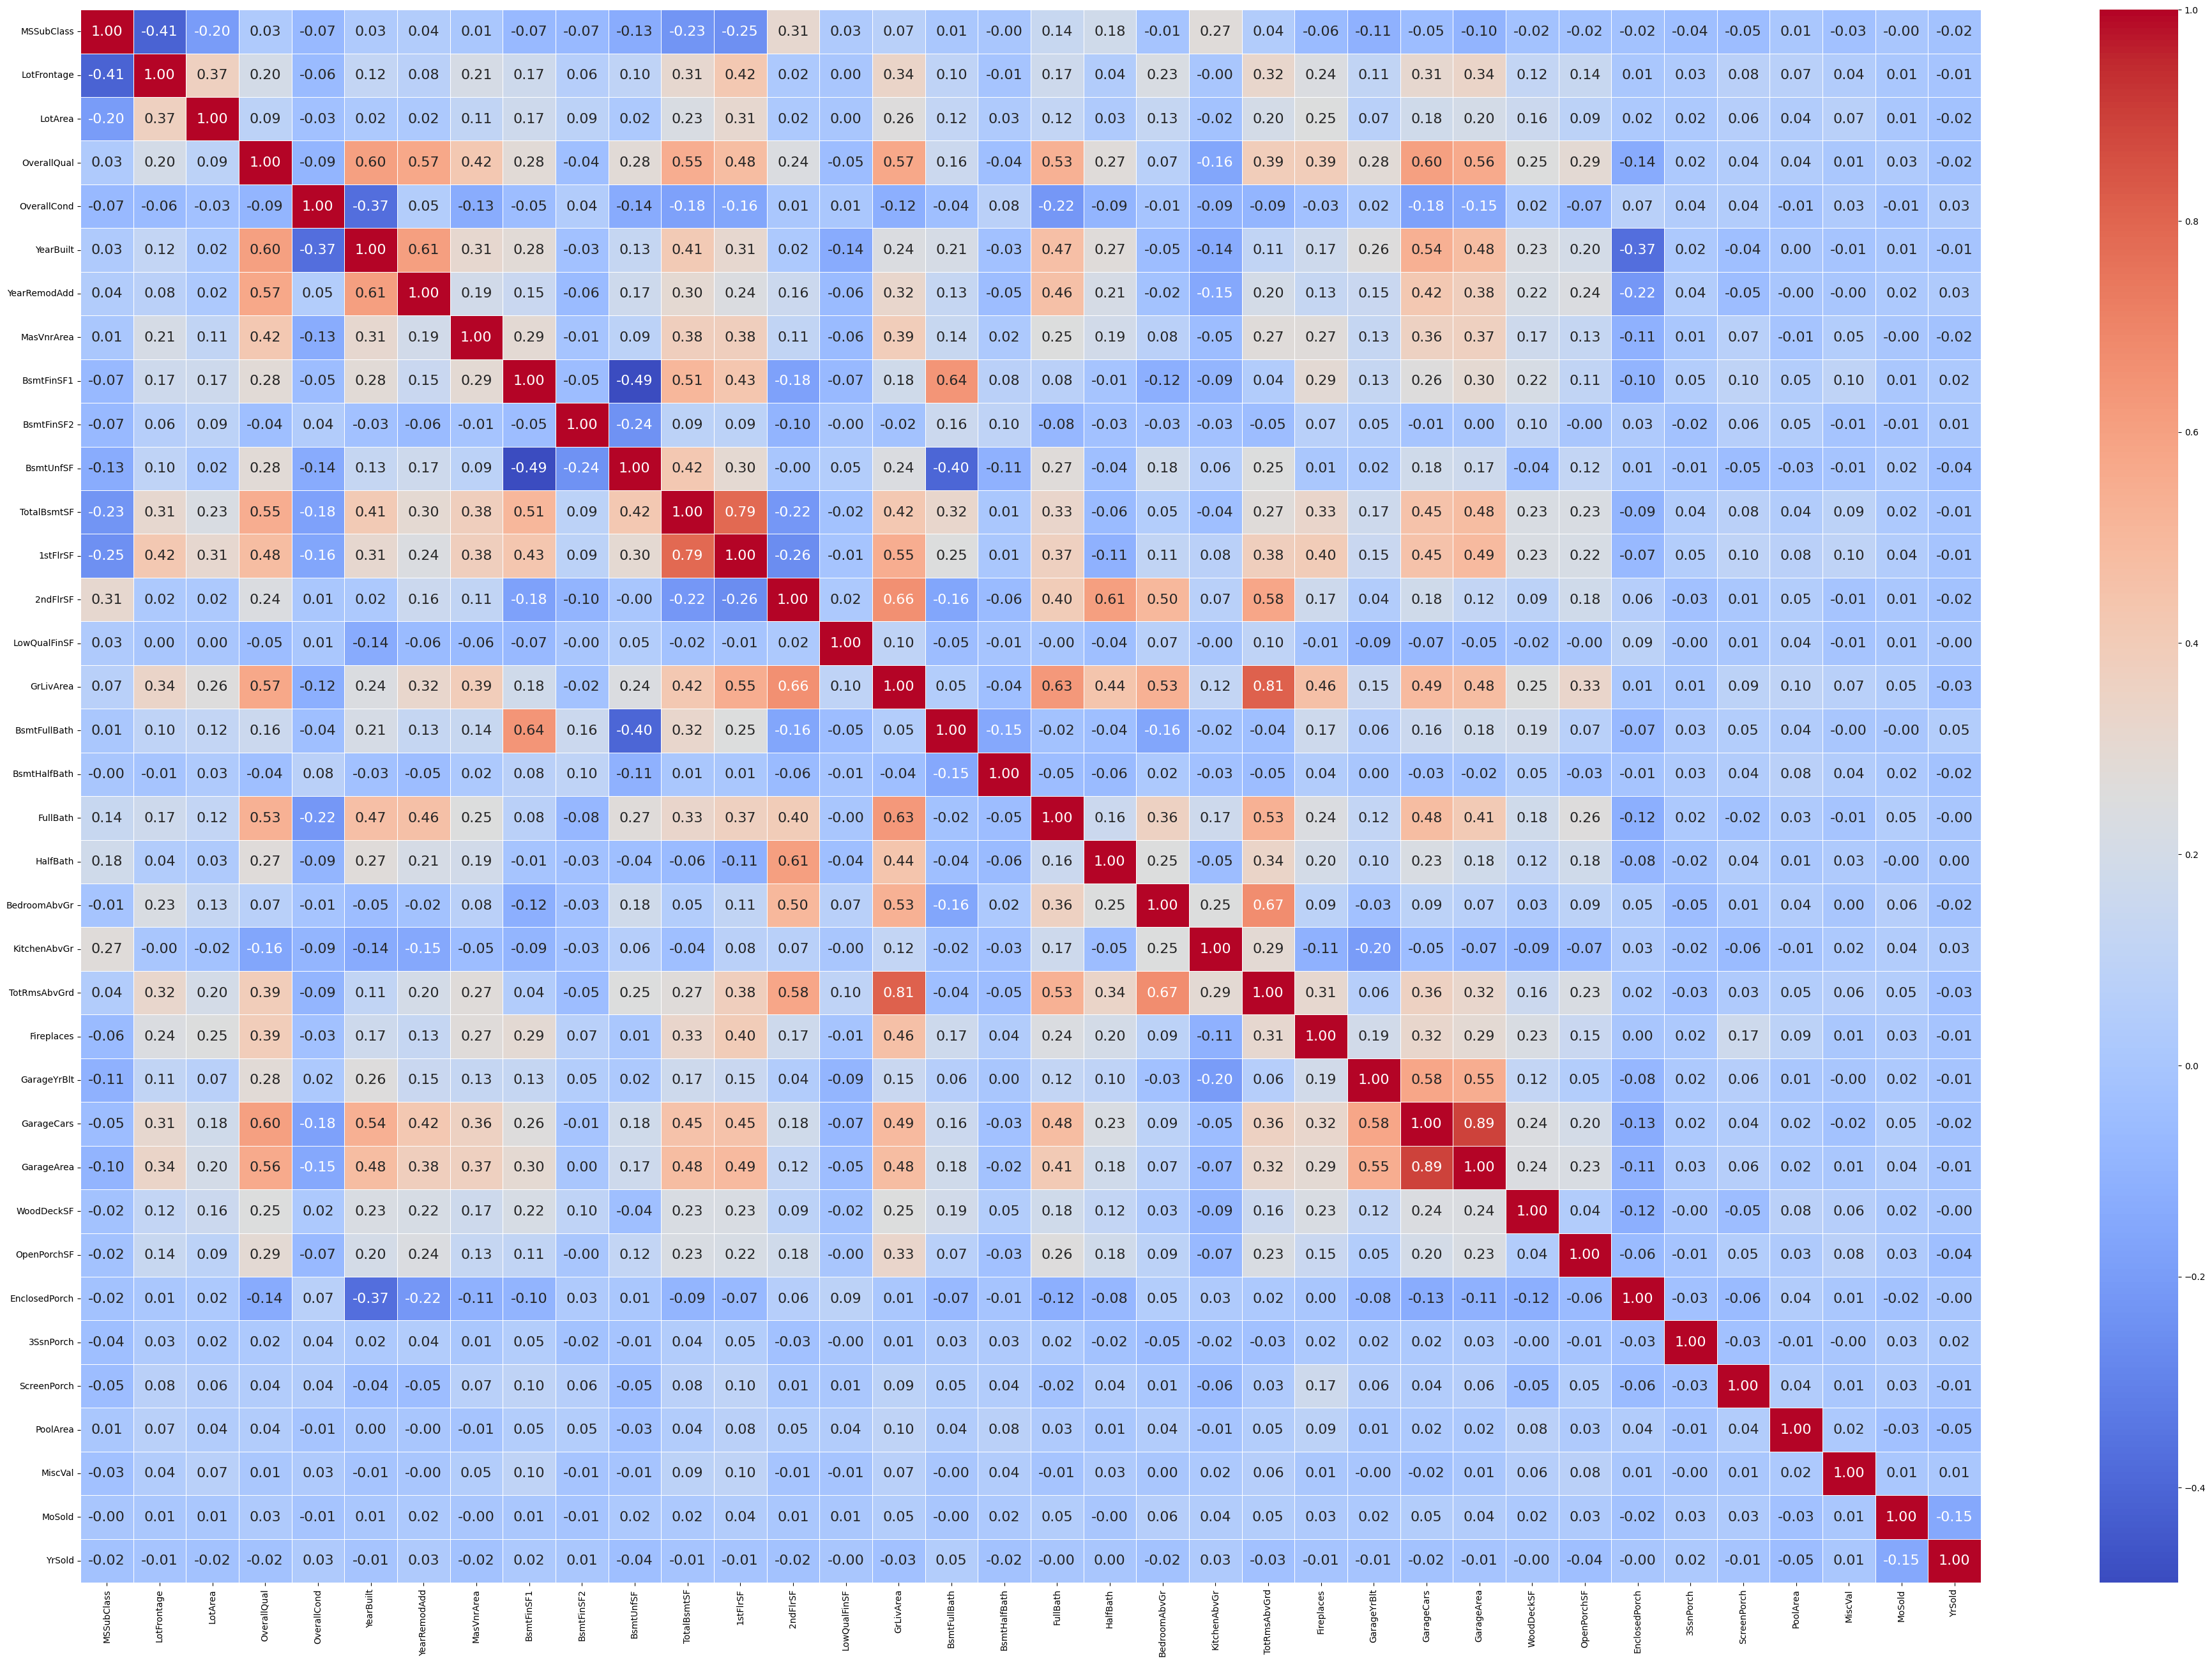

In [172]:
# Select only numeric columns for calculating the correlation matrix and exclude 'Id', 'SalePrice'
numeric_df = df_combined.select_dtypes(include='number').drop(columns=['Id'], errors='ignore')

# Calculate the correlation matrix
df_corr = numeric_df.corr().round(2)

# Create a heatmap
plt.figure(figsize=(48, 32))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt="0.2f", linewidths=0.5, annot_kws={"size": 16})

plt.show()

In [173]:
# Find highly correlated features
threshold = 0.75
high_corr_pairs = set()
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i, j]) > threshold:
            colname = df_corr.columns[i]
            rowname = df_corr.columns[j]
            high_corr_pairs.add((colname, rowname, df_corr.iloc[i, j]))
print("\nHighly Correlated Features (|correlation| > 0.75):")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} and {col2}: {corr:.2f}")


Highly Correlated Features (|correlation| > 0.75):
TotRmsAbvGrd and GrLivArea: 0.81
1stFlrSF and TotalBsmtSF: 0.79
GarageArea and GarageCars: 0.89


The correlation heatmap reveals three main feature pairs with high correlation (0.79-0.89): GarageArea/GarageCars, TotRmsAbvGrd/GrLivArea, and 1stFlrSF/TotalBsmtSF. These represent logical architectural relationships in housing data.

**Feature Engineering Plan:**
  - Combine garage features into GarageAreaPerCar ratio
  - Consolidate room/area measurements where beneficial
  - Create age-based features from year variables
  - Apply log transformation to skewed numerical features

### 2.2 Features with year

Create age-based features from year variables

In [174]:
# GarageAge instead of GarageYrBlt
df_combined['GarageAge'] = df_combined['YrSold'] - df_combined['GarageYrBlt']

# Define HasGarage feature based on GarageAge 
# GarageYrBlt was set to 0 for houses without a garage, which means GarageAge will be 1000 or more for those houses
df_combined['HasGarage'] = (df_combined['GarageAge'] < 1000).astype(int)

# Set GarageAge to 0 for houses without garage
df_combined.loc[df_combined['HasGarage'] == 0, 'GarageAge'] = 0

# HouseAge instead of YearBuilt
df_combined['HouseAge'] = df_combined['YrSold'] - df_combined['YearBuilt']

# YearsSinceRemodel instead of YearRemodAdd
df_combined['YearsSinceRemodel'] = df_combined['YrSold'] - df_combined['YearRemodAdd']

# Drop original year columns and 'MoSold'
df_combined = df_combined.drop(columns=['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'])


GarageAge has replaced GarageYrBlt to better reflect the age of the garage at the time of sale. HouseAge is derived from YearBuilt and YrSold to indicate the age of the house and YearsSinceRemodel is calculated from YearRemodAdd and YrSold to show how long it has been since the last remodel.

### 2.3 Basement and House Features with Square Feet
Create features based on square footage of basement and house

In [175]:
# Total square feet of finished basement
df_combined['BsmtFinSF'] = df_combined['BsmtFinSF1'] + df_combined['BsmtFinSF2']

# Total square feet of finished floors
df_combined['TotalFlrSF'] = df_combined['1stFlrSF'] + df_combined['2ndFlrSF']

# Drop individual square feet columns
df_combined.drop(['BsmtFinSF1'], axis=1, inplace=True)
df_combined.drop(['BsmtFinSF2'], axis=1, inplace=True)
df_combined.drop(['1stFlrSF'], axis=1, inplace=True)
df_combined.drop(['2ndFlrSF'], axis=1, inplace=True)
df_combined.drop(['TotalBsmtSF'], axis=1, inplace=True) # Isn't necessary since it's a sum of the other columns

BsmtFinSF has been created to represent the total square footage of finished basement space by summing BsmtFinSF1 and BsmtFinSF2. TotalFlrSF combines the first and second floor square footage, providing a comprehensive view of the house's total finished area. Individual square feet columns have been dropped to streamline the dataset.

### 2.4 Bathroom Features
Create features based on bathroom counts

In [176]:
# Total baths instead of individual bath features
# Calculate total baths as a combination of full, half, and basement baths
df_combined['TotalBaths'] = df_combined['FullBath'] + (0.5*df_combined['HalfBath']) + df_combined['BsmtFullBath'] + (0.5*df_combined['BsmtHalfBath'])

# Drop individual bath features
df_combined.drop(['FullBath'], axis=1, inplace=True)
df_combined.drop(['HalfBath'], axis=1, inplace=True)
df_combined.drop(['BsmtFullBath'], axis=1, inplace=True)
df_combined.drop(['BsmtHalfBath'], axis=1, inplace=True)

The new feature TotalBath combines the number of full and half bathrooms, providing a single metric for bathroom count.

### 2.4 Features about the garage
Create GarageAreaPerCar to represent the ratio of garage area to the number of cars it can accommodate

In [177]:
df_combined['GarageAreaPerCar'] = df_combined['GarageArea'] / df_combined['GarageCars']

# Fill in any nulls from feature engineering
df_combined['GarageAreaPerCar'].fillna(0, inplace=True)

df_combined.drop(['GarageArea'], axis=1, inplace=True)
df_combined.drop(['GarageCars'], axis=1, inplace=True)

The new feature GarageAreaPerCar is calculated by dividing GarageArea by GarageCars, providing a ratio that indicates how much garage space is available per car. This feature can help assess the efficiency of garage space utilization, and prevent multicollinearity issues with GarageArea and GarageCars.

## 3. Feature Transformation

Test numerical features for skewness and apply log transformation where necessary.

### 3.1 Skewness Analysis
Analyze numerical features for skewness.

In [178]:
# Create a list of the numerical data types after the feature engineering
numerical_cols = [cname for cname in df_combined.columns 
                  if df_combined[cname].dtypes != 'object' 
                  and cname not in ['SalePrice', 'Id', 'dataset_source']]  

# Create new dataframe with the numerical columns
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])

# Compute the skewness of the dataset
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: stats.skew(df_combined[feature]))

# Change Skew to a postive number
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)

# Create true/false columns based on if Absolute Skew is >=0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

# Display the dataframe
skew_df



,Feature,Skew,Absolute Skew,Skewed
0,MSSubClass,1.375131,1.375131,True
1,LotFrontage,1.102704,1.102704,True
2,LotArea,13.109495,13.109495,True
3,OverallQual,0.189591,0.189591,False
4,OverallCond,0.569314,0.569314,True
5,MasVnrArea,2.621719,2.621719,True
6,BsmtUnfSF,0.919688,0.919688,True
7,LowQualFinSF,12.084539,12.084539,True
8,GrLivArea,1.068750,1.068750,True
9,BedroomAbvGr,0.326568,0.326568,False


In [179]:
# Print number of skewed features
print(f"\nNumber of skewed features (|skew| >= 0.5): {skew_df['Skewed'].sum()}")

# Print overall average skewness
print(f"\nOverall average skewness: {skew_df['Absolute Skew'].mean():.2f}")


Number of skewed features (|skew| >= 0.5): 23

Overall average skewness: 4.07


23 features have a skewness greater than 0.5, indicating they are significantly skewed.

### 3.2 Skewed features with negative values
Find features that have a skewness greater than 0.5 and contain negative values, and clip them to a minimum of 0 before applying log transformation.

In [180]:
# Initialize a list to store features with negative values
negative_skewed_features = []

for feature in skew_df[skew_df['Skewed']]['Feature']:
    if (df_combined[feature] < 0).any():
        negative_skewed_features.append(feature)

# Display features with negative values
if negative_skewed_features:
    condition = df_combined[negative_skewed_features].lt(0).any(axis=1)
    negative_rows_df = df_combined.loc[condition, ['Id'] + negative_skewed_features]
    display(negative_rows_df.reset_index(drop=True))
else:
    print("No negative values found in skewed features.")

# Clip negative values to 0
for feature in negative_skewed_features:
    df_combined[feature] = df_combined[feature].clip(lower=0)
    print(f"Clipped negative values to 0 in {feature}.")


,Id,GarageAge,HouseAge
0,2550,-1,-1


Clipped negative values to 0 in GarageAge.
Clipped negative values to 0 in HouseAge.


Property ID 2550 (identified in notebook 2) has construction years after sale year due to incomplete build status. Clipping these to 0 prevents infinite values during log transformation. 

### 3.4 Log Transformation of Skewed Features
Apply log1p, a log transformation that handles zero values, to skewed features.

In [181]:
# Apply log1p transformation to df whose above a 0.5 absolute skew
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_combined[column] = np.log1p(df_combined[column])

In [182]:
# Show the updated dataframe
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: stats.skew(df_combined[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)   
skew_df


,Feature,Skew,Absolute Skew,Skewed
0,MSSubClass,0.245930,0.245930,False
1,LotFrontage,-1.069647,1.069647,True
2,LotArea,-0.532646,0.532646,True
3,OverallQual,0.189591,0.189591,False
4,OverallCond,-0.746912,0.746912,True
5,MasVnrArea,0.538454,0.538454,True
6,BsmtUnfSF,-2.154142,2.154142,True
7,LowQualFinSF,8.554639,8.554639,True
8,GrLivArea,-0.022051,0.022051,False
9,BedroomAbvGr,0.326568,0.326568,False


In [183]:
# Print number of skewed features
print(f"\nNumber of skewed features (|skew| >= 0.5): {skew_df['Skewed'].sum()}")

# Print overall average skewness
print(f"\nOverall average skewness: {skew_df['Absolute Skew'].mean():.2f}")


Number of skewed features (|skew| >= 0.5): 16

Overall average skewness: 2.28


The number of skewed features (|skew| >= 0.5) has been reduced from 22 to 16, indicating a more balanced distribution after transformation. The overall average skewness has also decreased from 4.07 to 2.28, suggesting a significant improvement in feature distribution.

## 4. Encoding categorical features
Encode categorical features using label encoding and one-hot encoding.

### 4.1 Show all categorical features
Display all categorical features identified in the dataset.

In [184]:
# Get list of categorical columns (exclude dataset_source as it's for tracking only)
categorical_columns_list = df_combined.select_dtypes(include='object').columns
categorical_columns_list = [col for col in categorical_columns_list if col != 'dataset_source'] 

# Create a new Dataframe containing only the categorical columns 
df_categorical = df_combined[categorical_columns_list].copy()

df_categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,Gable,CompShg,CmentBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,None,None,WD,Normal
2913,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,Gable,CompShg,CmentBd,CmentBd,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,CarPort,Unf,TA,TA,Y,None,None,None,WD,Abnorml
2914,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
2915,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,MnPrv,Shed,WD,Normal


### 4.2 Parser integration
Integrate the data description parser to identify which categorical features to encode with label encoding and which to encode with one-hot encoding.

In [185]:
# Get a list of all the categorical features and their descriptions
categorical_features = get_categorical_features(feature_descriptions)

# Load the description of each categorical feature
categorical_descriptions = {feature: feature_descriptions[feature] for feature in categorical_features if feature in feature_descriptions}
# Display the categorical features and their descriptions
for feature, description in categorical_descriptions.items():
    print(f"{feature}: {description}\n")

# Then get detailed info for categorical features only
categorical_features_list = get_categorical_features(feature_descriptions)
print(f"\nDetailed categorical features ({len(categorical_features_list)}):")
print("=" * 60)

for feature in categorical_features_list:
    display_feature_info(feature_descriptions, feature)
   



Detailed categorical features (46):
Feature: MSSubClass
Description: Identifies the type of dwelling involved in the sale.
Type: Categorical

Categories:
  20: 1-STORY 1946 & NEWER ALL STYLES
  30: 1-STORY 1945 & OLDER
  40: 1-STORY W/FINISHED ATTIC ALL AGES
  45: 1-1/2 STORY - UNFINISHED ALL AGES
  50: 1-1/2 STORY FINISHED ALL AGES
  60: 2-STORY 1946 & NEWER
  70: 2-STORY 1945 & OLDER
  75: 2-1/2 STORY ALL AGES
  80: SPLIT OR MULTI-LEVEL
  85: SPLIT FOYER
  90: DUPLEX - ALL STYLES AND AGES
  120: 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
  150: 1-1/2 STORY PUD - ALL AGES
  160: 2-STORY PUD - 1946 & NEWER
  180: PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
  190: 2 FAMILY CONVERSION - ALL STYLES AND AGES
------------------------------------------------------------
Feature: MSZoning
Description: Identifies the general zoning classification of the sale.
Type: Categorical

Categories:
  A: Agriculture
  C: Commercial
  FV: Floating Village Residential
  I: Industrial
  RH: Residen

The parser analysis reveals that 22 categorical features have inherent ordinal relationships and are suitable for label
encoding. Among these, 10 features share identical categorical value patterns (None/Po/Fa/TA/Gd/Ex), allowing for
standardized encoding. The remaining 12 ordinal features contain unique value hierarchies requiring individual encoding
mappings

### 4.3 Label Encoding
Apply manual label encoding to ordinal categorical features to preserve their natural hierarchy. This ensures proper
ordering from None (0) through Po, Fa, TA, Gd, to Ex (5), avoiding the arbitrary alphabetical ordering that automated
label encoders would impose.

In [186]:
# Label encode all the ordinal features with the same number of categories
ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                 'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_1:
    if 'None' in df_combined[col].value_counts().index:
        df_combined[col] = df_combined[col].map({"None":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}).astype('int')
    else:
        df_combined[col] = df_combined[col].map({"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5}).astype('int')

# Display the label encoded ordinal features
print("\nLabel encoded ordinal features with 5 categories:")
for col in ordinal_1:
    print(f"- {col}")



Label encoded ordinal features with 5 categories:
- ExterQual
- ExterCond
- BsmtQual
- BsmtCond
- HeatingQC
- KitchenQual
- FireplaceQu
- GarageQual
- GarageCond
- PoolQC


In [187]:
# Label encode all the ordinal features with different number of categories
ordinal_2 = ['LotShape', 'LandContour', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                 'Utilities', 'CentralAir', 'Functional', 'GarageFinish', 'PavedDrive', 'Fence']

df_combined['LotShape'] = df_combined['LotShape'].map({"None":0,"IR3":1,"IR2":2,"IR1":3,"Reg":4}).astype('int')
df_combined['LandContour'] = df_combined['LandContour'].map({"None":0,"Low":1,"Bnk":2,"HLS":3,"Lvl":4}).astype('int')
df_combined['LandSlope'] = df_combined['LandSlope'].map({"None":0,"Sev":1,"Mod":2,"Gtl":3}).astype('int')
df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map({"None":0, "No":1,"Mn":2,"Av":3,"Gd":4}).astype('int')
df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map({"None":0, "Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map({"None":0, "Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_combined['Utilities'] = df_combined['Utilities'].map({"None":0,"ELO":1,"NoSeWa":2,"NoSewr":3,"AllPub":4}).astype('int')
df_combined['CentralAir'] = df_combined['CentralAir'].map({"None":0,"N":1,"Y":2}).astype('int')
df_combined['Functional'] = df_combined['Functional'].map({"None":0,"Sal":1,"Sev":2,"Maj2":3,"Maj1":4,"Mod":5,"Min2":6,
                                         "Min1":7,"Typ":8}).astype('int')
df_combined['GarageFinish'] = df_combined['GarageFinish'].map({"None":0,"Unf":1,"RFn":2,"Fin":3}).astype('int')
df_combined['PavedDrive'] = df_combined['PavedDrive'].map({"None":0,"N":1,"P":2,"Y":3}).astype('int')
df_combined['Fence'] = df_combined['Fence'].map({"None":0, "MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}).astype('int')

# Display the label encoded ordinal features
print("\nLabel encoded ordinal features with different number of categories:")
for col in ordinal_2:
    print(f"- {col}")


Label encoded ordinal features with different number of categories:
- LotShape
- LandContour
- LandSlope
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- Utilities
- CentralAir
- Functional
- GarageFinish
- PavedDrive
- Fence


All the ordinal features have been label encoded

### 4.4 One-Hot Encoding
Apply one-hot encoding to the remaining categorical features

In [62]:
# Get remaining non-ordinal categorical columns (exclude dataset_source)
df_categorical = df_categorical.drop(columns=ordinal_1)
df_categorical = df_categorical.drop(columns=ordinal_2)

# Get the rest of the categorical data for one hot encoding
ohe_ = df_categorical.columns.tolist()

# Convert categorical columns to one-hot encoded columns, dropping the first column for each
df_encoded = pd.get_dummies(df_combined[ohe_], drop_first=True).astype(int)

# Preserve dataset_source when concatenating
dataset_source_col = df_combined['dataset_source'].copy()

# Concatenate the one-hot encoded columns with the original Dataframe (excluding the categorical columns we just encoded)
df_combined = pd.concat([df_combined.drop(columns=ohe_), df_encoded], axis=1)

# Restore dataset_source column
df_combined['dataset_source'] = dataset_source_col

### 4.5 Final Feature Set
Show the final feature set after encoding

In [63]:
print("Data Types Distribution (Combined Dataset):")
print(df_combined.dtypes.value_counts())

Data Types Distribution (Combined Dataset):
int64      167
float64     25
object       1
Name: count, dtype: int64


The final feature set includes all engineered features, with categorical features encoded using label encoding for ordinal data and one-hot encoding for nominal data. The one categorical feature is the dataset_source, which will be dropped when the datasets are split into train and test sets.

Target Variable Transformation:
Original SalePrice skewness: 1.879
Log transformed skewness: 0.121
Skewness improvement: +1.758


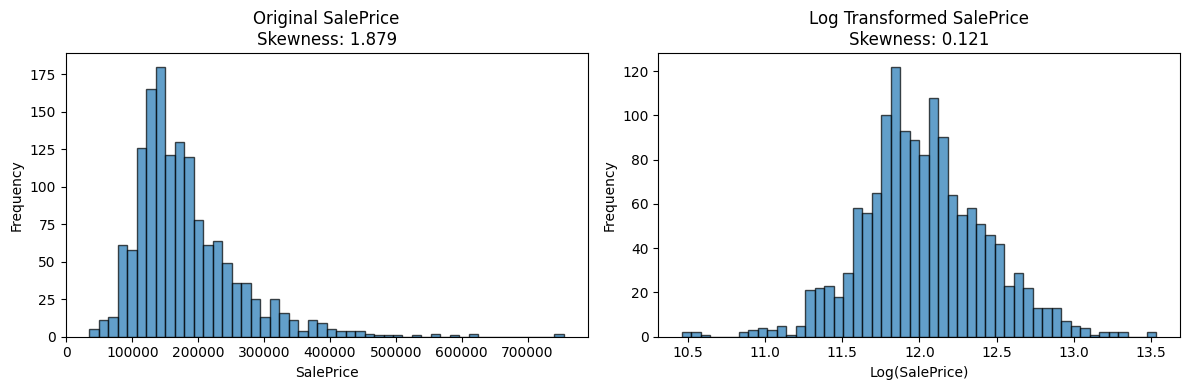

In [60]:
# Transform target variable (SalePrice)
print("Target Variable Transformation:")
print("="*40)

# Original target statistics
original_target_skew = stats.skew(target_series)
print(f"Original SalePrice skewness: {original_target_skew:.3f}")

# Apply log transformation to target
target_log = np.log(target_series)
transformed_target_skew = stats.skew(target_log)

print(f"Log transformed skewness: {transformed_target_skew:.3f}")
print(f"Skewness improvement: {original_target_skew - transformed_target_skew:+.3f}")

# Visualize transformation effect
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(target_series, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'Original SalePrice\nSkewness: {original_target_skew:.3f}')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(target_log, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'Log Transformed SalePrice\nSkewness: {transformed_target_skew:.3f}')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Store transformed target for later use
target_transformed = target_log

In [61]:
# Split back to train and test
train_mask = df_combined['dataset_source'] == 'train'
test_mask = df_combined['dataset_source'] == 'test'

# Exclude non-feature columns
feature_columns = [col for col in df_combined.columns if col not in ['dataset_source', 'Id']]

X_train_final = df_combined[train_mask][feature_columns]
X_test_final = df_combined[test_mask][feature_columns]
y_train_final = target_transformed

# Display final shapes
print(f"Final Training data shape: {X_train_final.shape}")
print(f"Final Test data shape: {X_test_final.shape}")
print(f"Number of features: {len(feature_columns)}")

Final Training data shape: (1458, 191)
Final Test data shape: (1459, 191)
Number of features: 191


In [62]:
# Export final datasets
X_train_final.to_csv('../data/processed/X_train_final1.csv', index=False)
X_test_final.to_csv('../data/processed/X_test_final1.csv', index=False)
y_train_final.to_csv('../data/processed/y_train_final1.csv', index=False)